# Testing the number of bumps that best explains the data

We usually do not have precise enough information to decide a priori on a number of bumps that an HsM model should have. To illustrate the problem let's use the data from application 2 of this [this](https://link.springer.com/article/10.1007/s42113-021-00105-2) paper that we already prepared in section 1 of tutorial 1 and saved in ```sample_data/```. For the purpose of this tutorial we will only use the last four participants of the data (see [this](https://www.sciencedirect.com/science/article/pii/S1053811914002249) paper for the method and [https://osf.io/pd3kf/](https://osf.io/pd3kf/) for the whole (unpreprocessed) data)


In [2]:
import numpy as np
import xarray as xr
import hsmm_mvpy as hsmm

cpus = 10

eeg_data = xr.load_dataset('sample_data/sample_data.nc')

#We create also the position array for the electrodes as we are going to need them to plot the bump topologies
from mne import channels
montage = dict(channels.make_standard_montage('easycap-M1').get_positions())['ch_pos']#In this case electrodes are positioned according to the 10-20 system
positions = np.array([montage[x][:2] for x in eeg_data['electrodes'].values])#Extract x and y positions of each electrode

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Data preparation

First let's transform the data in principal component (PC) space

In [3]:
eeg_data

<xarray.Dataset>
Dimensions:      (epochs: 200, electrodes: 30, samples: 210, participant: 4)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * electrodes   (electrodes) object 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 203 204 205 206 207 208 209
  * participant  (participant) object '0025' '0024' '0023' '0022'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 2.891e+06...
    event        (participant, epochs) object 'SP/stim_right/resp_left' ... '...
Attributes:
    sfreq:    100

When transforming the data, a prompt request us how many PC we want to keep. The best is to maximise the number of component kept so that we don't loose PC with useful information, but the more PC we include the more computationally intensive the estimations will be. For this two rules of thumb exists, taking PC that explain x% of the variance of the data or select the PC number at which the explained variance seems to almost stop decreasing (i.e. the "elbow" method)

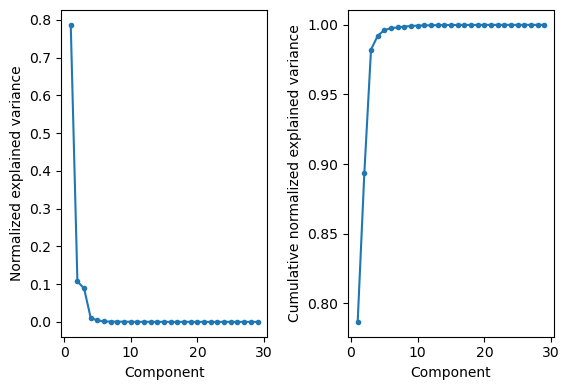

How many PCs (90 and 99% explained variance at component n3 and n4)? 6


In [4]:
hsmm_data = hsmm.utils.transform_data(eeg_data)

In this case we see that 99% is achieved with 4 PCs and this is globally coherent with when the explained variance really drops (with a larger number of electrodes than the 30 used here, 99% might be achieved with a lot more PC but the elbow might occur before that). However in the case of so little participants (3) we can take more PCs as the data is not that big and in the case of PC selection the more the better.

In [5]:
hsmm_data

<xarray.DataArray (component: 6, all_samples: 52203)>
array([[-0.2046566 , -0.05111144, -0.08774414, ..., -0.50939348,
        -0.55622432, -0.40675313],
       [-0.61778236, -1.03023408, -0.36316206, ..., -0.34094971,
        -0.21139061, -0.37995304],
       [ 1.02769673,  1.5379683 ,  2.21930863, ...,  1.60175226,
         1.59015816,  1.01581133],
       [-0.4950929 ,  1.4196772 ,  0.25208962, ..., -1.39781108,
        -0.60134774, -0.07047409],
       [-1.86107248, -1.42898441,  1.50718557, ..., -0.76614202,
        -0.98781377, -0.54259851],
       [-0.5380861 ,  2.08209123,  0.31340326, ..., -0.43418327,
        -0.3305331 , -0.60718833]])
Coordinates:
  * component    (component) int64 0 1 2 3 4 5
  * all_samples  (all_samples) object MultiIndex
  * participant  (all_samples) object '0022' '0022' '0022' ... '0025' '0025'
  * epochs       (all_samples) int64 0 0 0 0 0 0 0 ... 199 199 199 199 199 199
  * samples      (all_samples) int64 0 1 2 3 4 5 6 7 ... 95 96 97 98 99 100 101

And we initialize the model

In [6]:
#Before that we select only the accuracy condition in the experiment as mixing conditions together 
#might not well represent what happens in each condition (see Tutorial 4)
hsmm_data = hsmm.utils.condition_selection(hsmm_data, eeg_data, 'AC')#select the conditions where participants needs to be fast
init = hsmm.models.hsmm(hsmm_data, eeg_data, bump_width=50, cpus=15)

Fitting 85 models using grid search


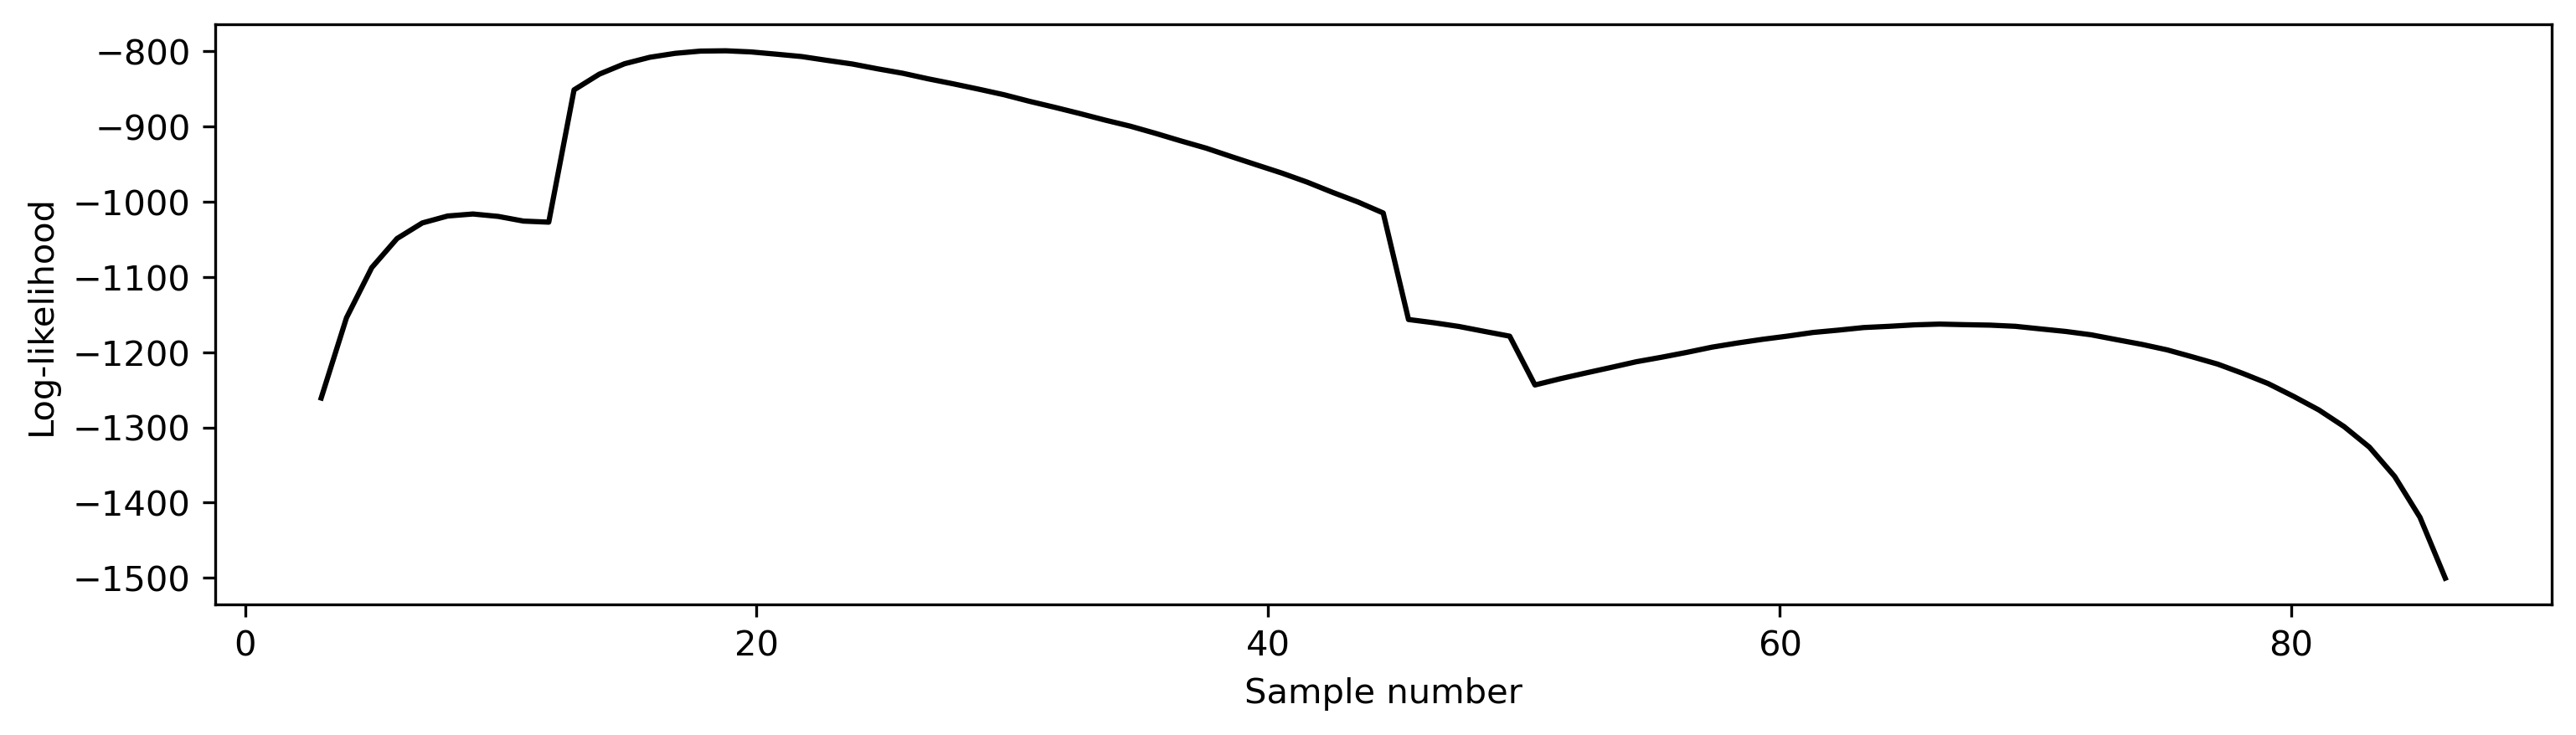

In [7]:
init.sliding_bump(method=None)

# Discovering a bump number through a cumulative approach

The ```fit``` function 

In [8]:
%%time
estimates = init.fit(step=1, threshold=1)

  0%|          | 0/89 [00:00<?, ?it/s]

Transition event 2 found around sample 27 (step 0): Transition event samples = [11. 27.]
Transition event 3 found around sample 44 (step 1): Transition event samples = [11. 25. 44.]
Transition event 4 found around sample 70 (step 2): Transition event samples = [11. 25. 44. 70.]
Estimating 4 bumps model
Parameters estimated for 4 bumps model
CPU times: user 7.61 s, sys: 36.4 ms, total: 7.65 s
Wall time: 7.68 s


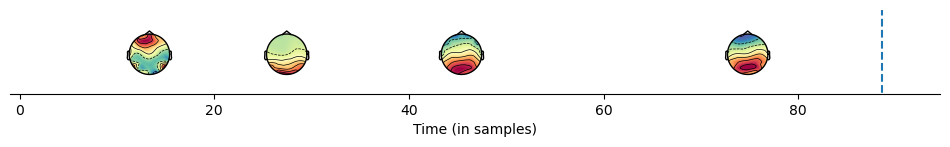

In [9]:
hsmm.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, times_to_display=np.mean(init.ends - init.starts))

With large dataset computation time might be very long, in this case you can use the step argument to skip some points between 0 and mean RT

In [10]:
%%time
estimates = init.fit(step=4, threshold=1)

  0%|          | 0/88 [00:00<?, ?it/s]

Transition event 2 found around sample 27 (step 0): Transition event samples = [11. 27.]
Transition event 3 found around sample 44 (step 1): Transition event samples = [11. 25. 44.]
Transition event 4 found around sample 70 (step 2): Transition event samples = [11. 25. 44. 70.]
Estimating 4 bumps model
Parameters estimated for 4 bumps model
CPU times: user 9.31 s, sys: 17.9 ms, total: 9.33 s
Wall time: 9.36 s


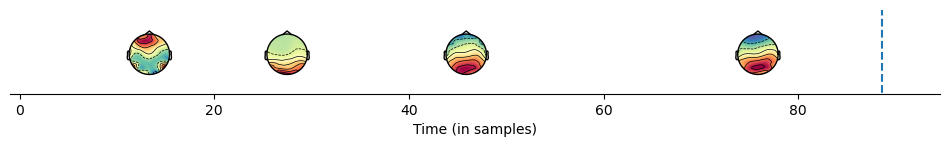

In [11]:
hsmm.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, times_to_display=np.mean(init.ends - init.starts))

In this example we evaluated the likelihood of (cumulatively) placing a bump every 4 sample. This resulted in a modest speed up but the benefit can be dramatic for larger dataset. Keep in mind though that skipping too much samples might overly distord the bump detection (in this specific case going for steps higher than 4 results in missing the last bump as its stage is short). A good rule of thumb is to never exceed a bump width in samples and to always check against the function fitted on more points (i.e. smaller steps).

We can also inspect the traces of the algorithm, if we provide the argument for it before the fit

In [12]:
estimates, traces = init.fit(step=4, threshold=1, trace=True, verbose=False)

  0%|          | 0/88 [00:00<?, ?it/s]

Calling the ```plot_iterations``` of the visualization module then plots the proposed magnitudes in the algorithm at each iteration. In the case of the last cell, the "time course" of the algorithm is the following:

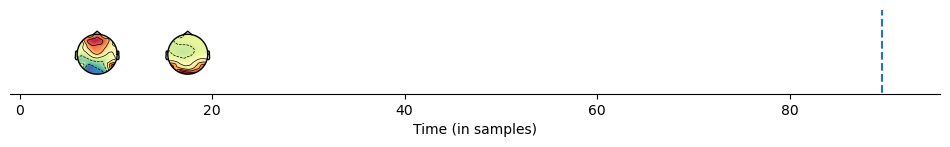

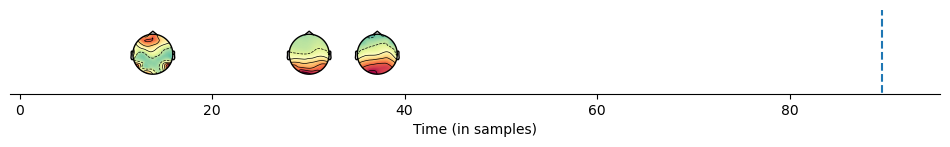

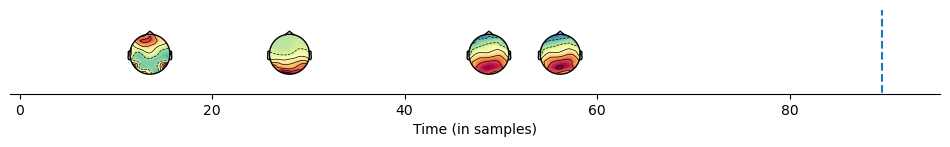

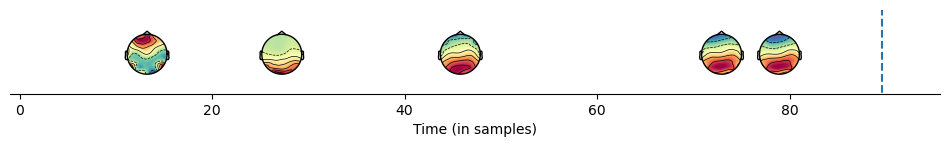

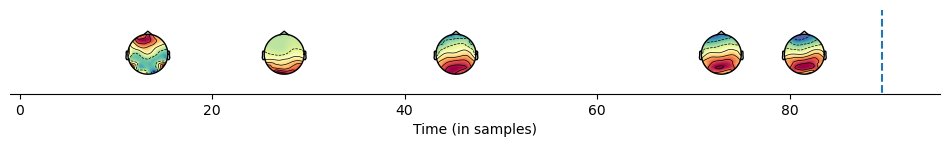

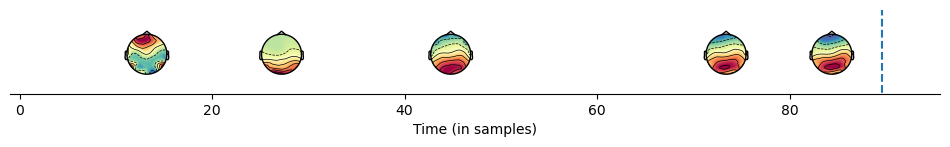

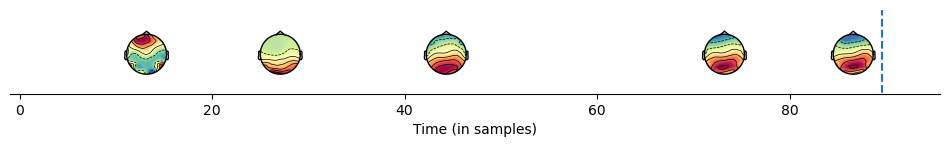

In [13]:
hsmm.visu.plot_iterations(traces, eeg_data, init, positions, ['magnitudes_proposed','parameters_proposed'])

This is also how you might see whether some events might have been overlooked. Now EEG data is noisy and you might find more or less bumps with a given threshold. A way to assess this variation is to use the bootstrapping method.

### Illustration of the principle of bootstrapping

In the case of EEG data for a group or even a single participant we can bootstrap the epochs or trials of the EEG. The idea is that 1) generating a bootstraped dataset, 2) fitting a model using the cumulative approach and 3) recording the parameters of the HMP model. We expect that with enough bootstrapped sampels we will know wich bumps tend to be rare (e.g. strategies) and what is the variance in time and electrode contribution.

In [14]:
import xskillscore as xs
bootstapped = xs.resample_iterations(hsmm_data.unstack(), iterations=1, dim='epochs')
hsmm_data_boot = hsmm.utils.stack_data(bootstapped.squeeze())
init_boot = hsmm.models.hsmm(hsmm_data_boot, sfreq=eeg_data.sfreq, bump_width=50, cpus=15)
estimates_boot = init_boot.fit(threshold = 1)

  0%|          | 0/89 [00:00<?, ?it/s]

Transition event 2 found around sample 27 (step 0): Transition event samples = [11. 27.]
Transition event 3 found around sample 44 (step 1): Transition event samples = [11. 26. 44.]
Transition event 4 found around sample 75 (step 2): Transition event samples = [11. 26. 44. 75.]
Estimating 4 bumps model
Parameters estimated for 4 bumps model


Next we compare to the times that we estimated on the general run:

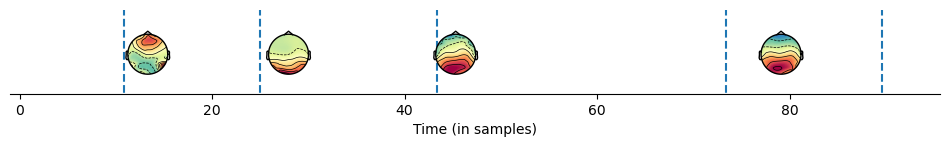

In [15]:
times_general_run = init.compute_times(init, estimates, duration=False, mean=True, add_rt=True)
hsmm.visu.plot_topo_timecourse(eeg_data, estimates_boot, positions, init, 
                               times_to_display=times_general_run.values)

Of course this is automated in the HMP package, here an example for 10 iterations.

In [16]:
booted = hsmm.utils.bootstrapping(init, hsmm_data, estimates, positions, eeg_data, iterations=10, threshold=1, cpus=cpus, plots=False, verbose=False)

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

We can then plot the bootstrapped models (or leave the plots argument as True when calling the previous function).

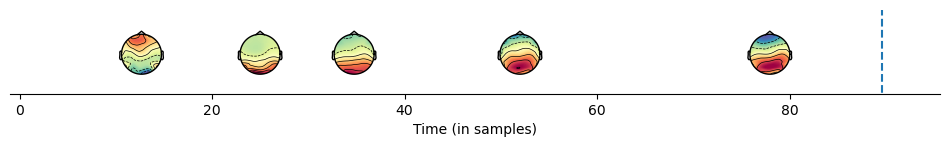

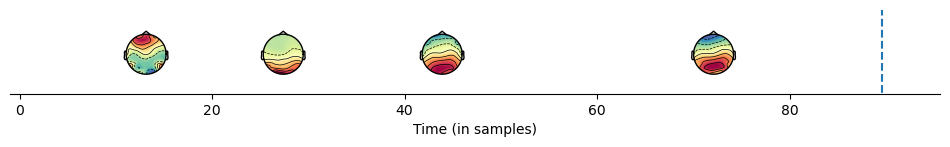

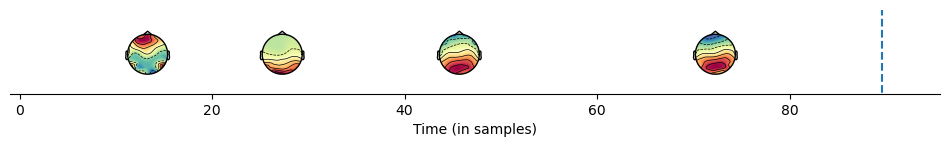

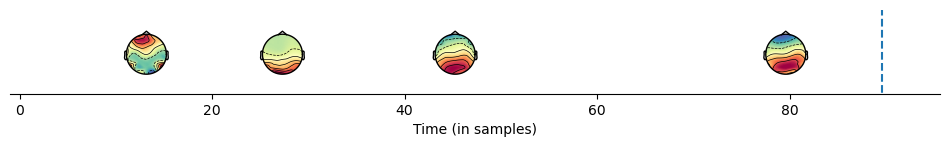

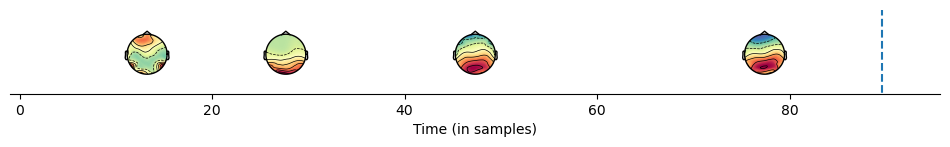

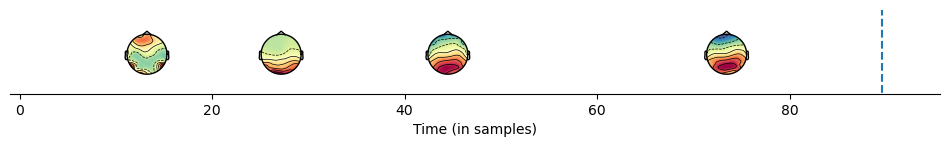

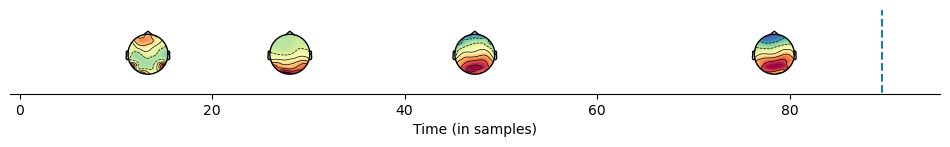

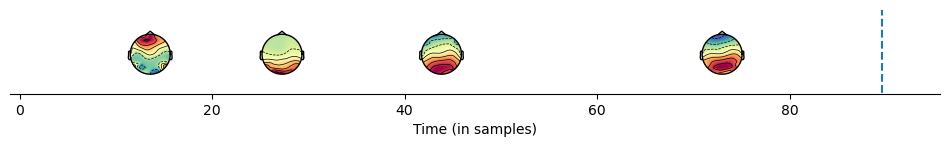

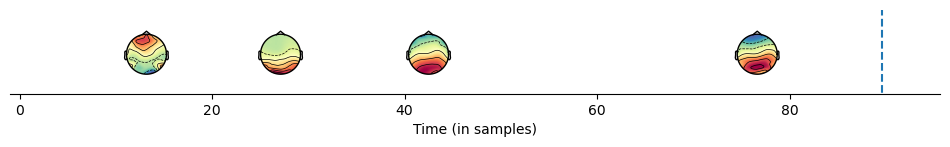

In [17]:
hsmm.visu.plot_iterations(booted, eeg_data, init, positions, ['magnitudes','parameters'])

We can then use these bootstrapped data to 1) assess variability in bump detection for a given threshold and 2) the variation in the location of the bumps and electrode contribution for a given _n_ bump model

## Fitting from the maximum number of bump to a 1 bump model

An alternative way of assessing the number of bumps is to use the ```backward_estimation``` as discussed in the previous tutorial

Estimating 12 bumps model with 0 starting point(s)
Parameters estimated for 12 bumps model


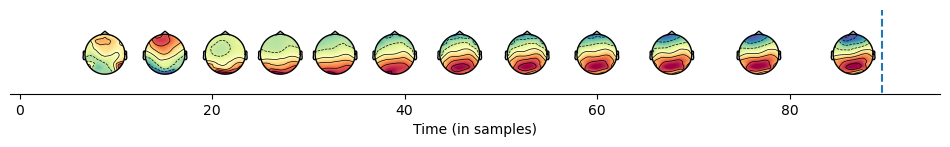

In [18]:
max_fit = init.fit_single(init.compute_max_bumps()-1, starting_points=0)
hsmm.visu.plot_topo_timecourse(eeg_data, max_fit, positions, init)

In [19]:
%%time 
bests = init.backward_estimation(max_fit=max_fit)#we can also leave the max_fit argument empty and it will be computed as above

Estimating all solutions for 11 number of bumps
Estimating all solutions for 10 number of bumps
Estimating all solutions for 9 number of bumps
Estimating all solutions for 8 number of bumps
Estimating all solutions for 7 number of bumps
Estimating all solutions for 6 number of bumps
Estimating all solutions for 5 number of bumps
Estimating all solutions for 4 number of bumps
Estimating all solutions for 3 number of bumps
Estimating all solutions for 2 number of bumps
Estimating all solutions for 1 number of bumps
CPU times: user 5.02 s, sys: 5.77 s, total: 10.8 s
Wall time: 1min 59s


Here we plot the resulting solutions going from the maximal possible number of bumps that fit into the minimum RT given a minimum duration of 25ms (default) in this example .

In [20]:
bests

<xarray.Dataset>
Dimensions:              (n_bumps: 12, stage: 13, parameter: 2, bump: 12,
                          component: 6, trial_x_participant: 374, samples: 210)
Coordinates:
  * bump                 (bump) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * samples              (samples) int64 0 1 2 3 4 5 ... 204 205 206 207 208 209
  * trial_x_participant  (trial_x_participant) object MultiIndex
  * participant          (trial_x_participant) object '0022' '0022' ... '0025'
  * trials               (trial_x_participant) int64 0 3 4 5 ... 174 175 179 181
  * n_bumps              (n_bumps) int64 12 11 10 9 8 7 6 5 4 3 2 1
Dimensions without coordinates: stage, parameter, component
Data variables:
    likelihoods          (n_bumps) float64 800.3 1.344e+03 ... -1.613 -814.8
    parameters           (n_bumps, stage, parameter) float64 2.0 3.182 ... nan
    magnitudes           (n_bumps, bump, component) float64 -0.9878 ... nan
    eventprobs           (n_bumps, trial_x_participant, samples, bump) float64 ...

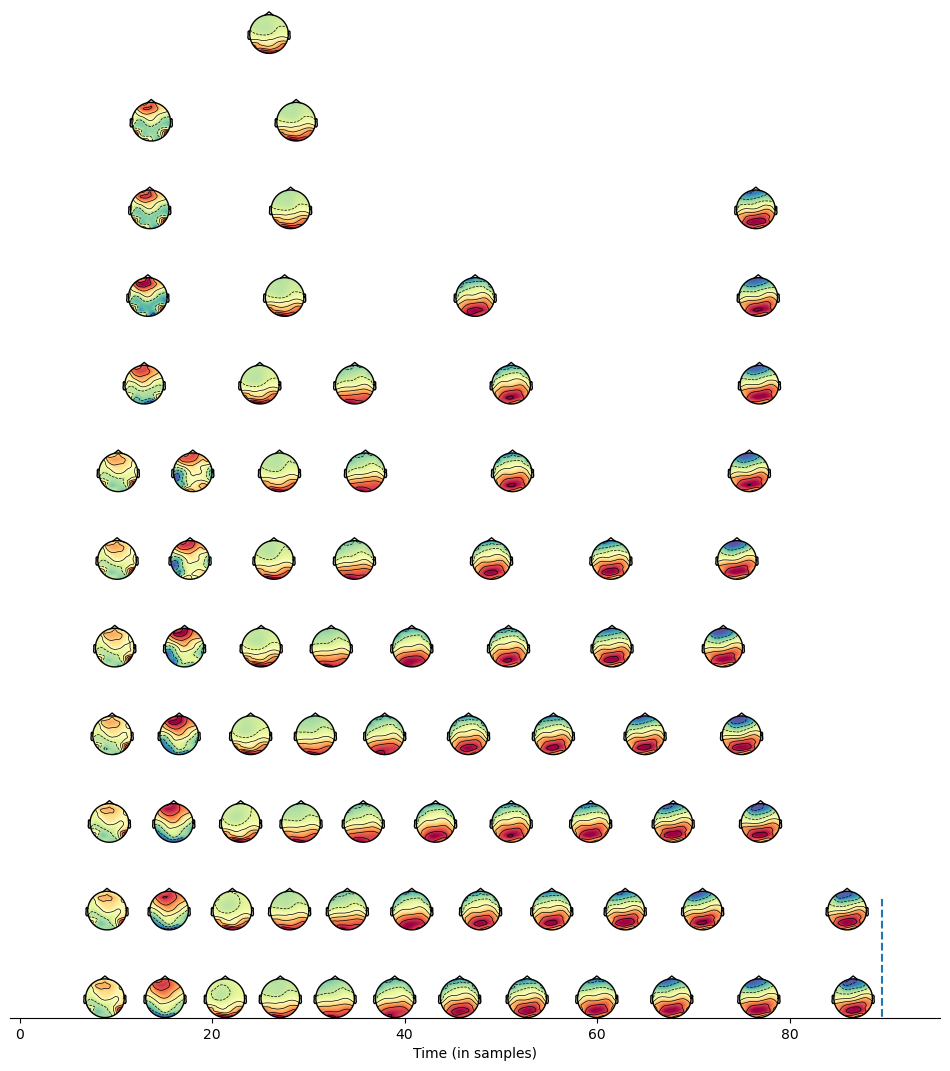

In [21]:
hsmm.visu.plot_topo_timecourse(eeg_data, bests, positions, init, ydim='n_bumps')

But adding more and more parameters will almost always improve the fit (except when bumps start pushing each other because of the defined minimum duration). To illustrate this we can plot the raw likelihood

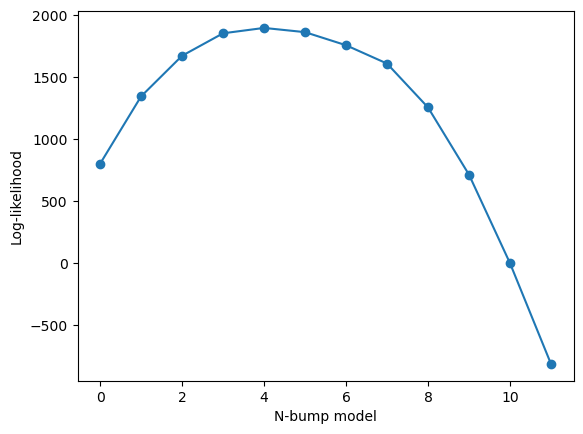

In [22]:
import matplotlib.pyplot as plt 

plt.plot(bests.likelihoods,'o-')

plt.ylabel('Log-likelihood')
plt.xlabel('N-bump model')
plt.show()

Hence we need a way to penalize the likelihood if the bumps location do not generalize to all participants. One way to do this is to perform a leave-one out cross-validation. This approach consists in fitting the model to all participants but one, and evaluate the likelihood of the left out participant given the estimated parameters without the participant. The function ```hsmm.utils.loocv_mp``` does this and we can apply it to all participants and all *n* bump model.

Note that the LOOCV can be very slow when there are a lot of participants, in this case it might be worth it to add multiprocessing through the cpus parameter

In [23]:
%%time
loocv = hsmm.utils.loocv_mp(init, hsmm_data, bests, cpus=cpus)#We set the cpus to 4 as their is 4 participants in the dataset

LOOCV for model with 12 bump(s)
LOOCV for model with 11 bump(s)
LOOCV for model with 10 bump(s)
LOOCV for model with 9 bump(s)
LOOCV for model with 8 bump(s)
LOOCV for model with 7 bump(s)
LOOCV for model with 6 bump(s)
LOOCV for model with 5 bump(s)
LOOCV for model with 4 bump(s)
LOOCV for model with 3 bump(s)
LOOCV for model with 2 bump(s)
LOOCV for model with 1 bump(s)
CPU times: user 1.65 s, sys: 3.6 s, total: 5.26 s
Wall time: 23.5 s


We can then plot the result from the LOOCV procedure

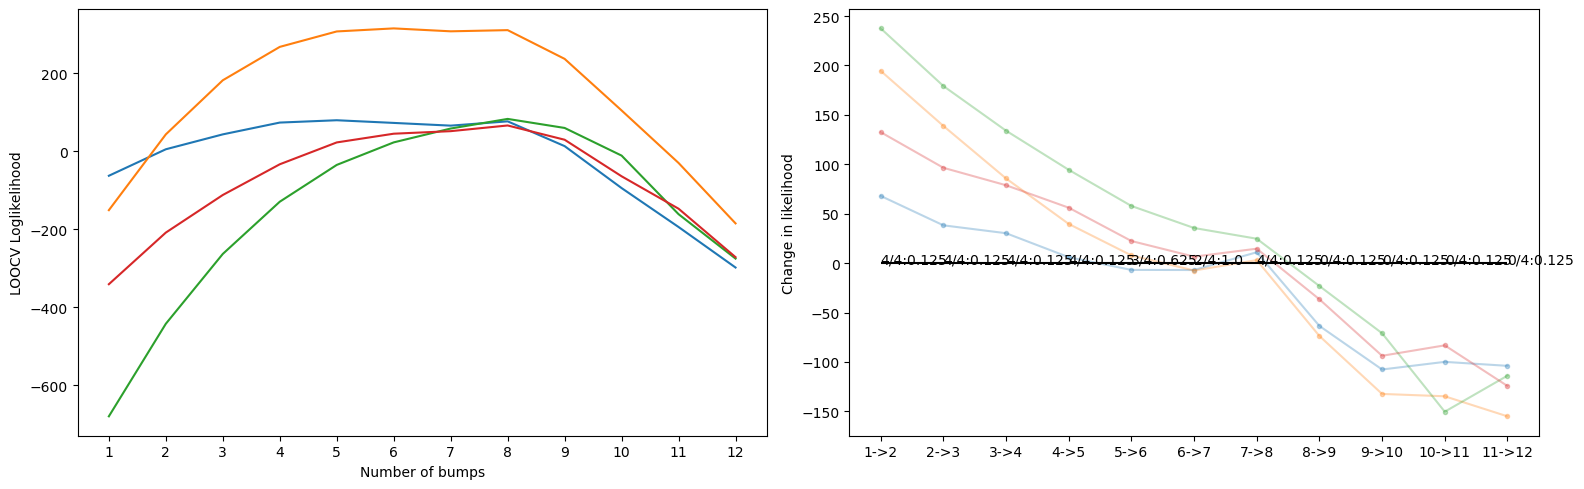

In [24]:
hsmm.visu.plot_LOOCV(loocv, pvals=True, test='sign', indiv=True)#Colored shaded lines represent individuals

Based on the numer of participant that improved (4/4) the model with 5 bumps appears to be the prefered model after the LOOCV procedure. Additionally the figure contains the p-value for a sign test but with only 4 participants we cannot have a significant difference.

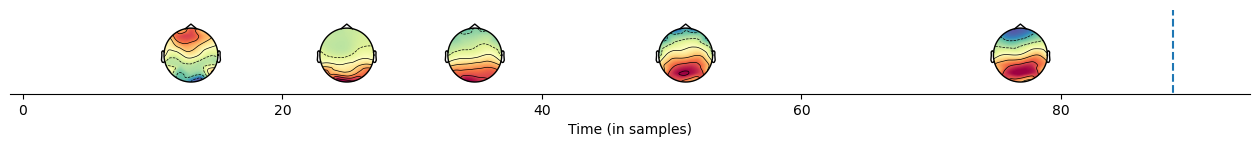

In [25]:
selected = bests.sel(n_bumps=5)

hsmm.visu.plot_topo_timecourse(eeg_data, selected, positions, init,  figsize=(16,1),
                                time_step = 1,  times_to_display = np.mean(init.ends - init.starts))

And we can now inspect specific aspects of that fit, see the next tutorial